In [42]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

In [43]:
# (Assuming data loading and model training are done as before)
# Load and preprocess data (recap)
data = pd.read_csv("diabetes.csv")
X = data.drop(columns=["Class", "Gender"])
X

,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI
0,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0
1,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0
2,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0
3,45,2.3,24,4.0,2.9,1.0,1.0,1.5,0.4,21.0
4,50,2.0,50,4.0,3.6,1.3,0.9,2.1,0.6,24.0
...,...,...,...,...,...,...,...,...,...,...
259,61,24.0,401,7.0,4.3,2.9,0.4,2.7,1.3,30.0
260,61,24.0,401,7.0,4.3,2.9,0.4,2.7,1.3,36.6
261,60,20.8,800,9.0,2.3,1.1,0.9,0.9,0.5,33.0
262,56,20.8,800,9.0,4.6,2.0,1.2,2.5,0.9,35.0


In [44]:
from sklearn.preprocessing import StandardScaler

# Label encoding for the target variable
le = LabelEncoder()
y = le.fit_transform(data["Class"])

# Normalization for the features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

In [45]:

# Train XGBoost model (recap)
xgb_model = xgb.XGBClassifier(
    objective="multi:softprob", num_class=3, eval_metric="mlogloss", 
    use_label_encoder=False, random_state=42
)
xgb_model.fit(X_train, y_train)

/home/aphuc/ai/workspace/xdoc/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:57:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=3, ...)

In [49]:
# Test model
y_pred = xgb_model.predict(X_test)
accuracy = (y_pred == y_test).mean()
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.97


In [35]:
# Compute SHAP values
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
print(f"SHAP values shape: {shap_values.shape}")  # Confirm (n_samples, n_features, 3)

SHAP values shape: (80, 10, 3)


In [39]:
# Select single patient
single_patient = X_test[0]

# Predict
predicted_class = xgb_model.predict(single_patient.reshape(1, -1))[0]
probabilities = xgb_model.predict_proba(single_patient.reshape(1, -1))[0]
class_labels = le.classes_  # ['Diabetic', 'Non-Diabetic', 'Pre-Diabetic']
print(f"Predicted Class: {class_labels[predicted_class]}")
print(f"Probabilities: {dict(zip(class_labels, probabilities))}")

Predicted Class: 0
Probabilities: {np.int64(0): np.float32(0.99747), np.int64(1): np.float32(0.0022037833), np.int64(2): np.float32(0.00032618872)}


In [ ]:
# Extract SHAP values for the single patient
# shap_values[0, :, :] gives (n_features, 3) for the first patient
shap_values_single = shap_values[0, :, :]  # Shape: (n_features, 3)

# Print SHAP values for the predicted class
predicted_class_idx = predicted_class  # e.g., 0 for Diabetic
print(f"\nSHAP Values for {class_labels[predicted_class_idx]}:")
for feature, shap_val in zip(X.columns, shap_values_single[:, predicted_class_idx]):
    print(f"{feature}: {shap_val:.4f}")


SHAP Values for 0:
AGE: 0.0000
Urea: 0.0979
Cr: 0.0000
HbA1c: 2.6636
Chol: 0.1115
TG: 0.3535
HDL: 0.0032
LDL: 0.0000
VLDL: 0.1286
BMI: 0.0873


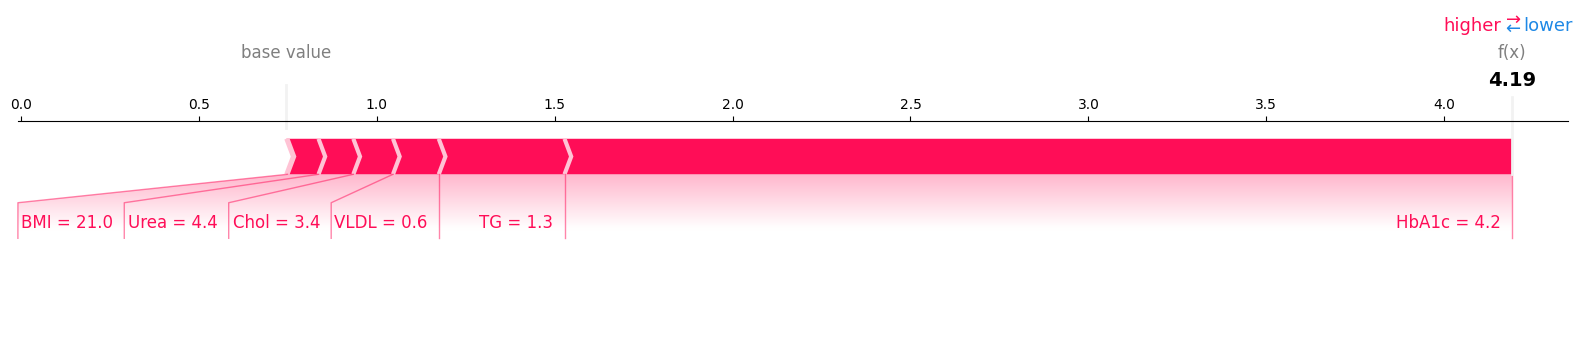


SHAP Contributions for 0:
AGE: 0.0000
Urea: 0.0979
Cr: 0.0000
HbA1c: 2.6636
Chol: 0.1115
TG: 0.3535
HDL: 0.0032
LDL: 0.0000
VLDL: 0.1286
BMI: 0.0873

SHAP Contributions for 1:
AGE: 0.4337
Urea: 0.0489
Cr: -0.0141
HbA1c: -1.4181
Chol: -0.0622
TG: -0.1578
HDL: -0.0171
LDL: 0.0456
VLDL: 0.0000
BMI: -0.0117

SHAP Contributions for 2:
AGE: -0.6865
Urea: -0.4039
Cr: -0.0224
HbA1c: -2.9856
Chol: -0.4444
TG: -0.1115
HDL: 0.0061
LDL: -0.3136
VLDL: 0.0000
BMI: -0.2772


In [ ]:

# Force plot for the predicted class
# Note: Convert to list for feature names compatibility
shap.force_plot(
    explainer.expected_value[predicted_class_idx],
    shap_values_single[:, predicted_class_idx],
    single_patient,
    feature_names=X.columns.tolist(),
    matplotlib=True
)
plt.show()

# Optional: Compare SHAP values across all classes
for i, class_name in enumerate(class_labels):
    print(f"\nSHAP Contributions for {class_name}:")
    for feature, shap_val in zip(X.columns, shap_values_single[:, i]):
        print(f"{feature}: {shap_val:.4f}")

In [ ]:
import os
from google import genai
from google.genai import types
from dotenv import load_dotenv
load_dotenv("key.env")

def generate(prompt):
    key = os.environ.get("GEMINI_API_KEY")
    if key is None:
        raise ValueError("Please set the GEMINI_API_KEY environment variable")
    client = genai.Client(
        api_key=os.environ.get("GEMINI_API_KEY"),
    )

    model = "gemini-2.0-flash"
    contents = [
        types.Content(
            role="user",
            parts=[
                types.Part.from_text(text=prompt),
            ],
        ),
    ]
    generate_content_config = types.GenerateContentConfig(
        temperature=1,
        top_p=0.95,
        top_k=40,
        max_output_tokens=8192,
        response_mime_type="text/plain",
    )

    for chunk in client.models.generate_content_stream(
        model=model,
        contents=contents,
        config=generate_content_config,
    ):
        print(chunk.text, end="")

In [56]:
import numpy as np
import pandas as pd

# Assume xgb_model is your trained XGBoost model, X_test is your test data
# and class_labels = ["Non-Diabetic", "Pre-Diabetic", "Diabetic"]

# Select a single patient
single_patient = X_test[0]
predicted_class = xgb_model.predict(single_patient.reshape(1, -1))[0]
probabilities = xgb_model.predict_proba(single_patient.reshape(1, -1))[0]

# Calculate SHAP values (assuming explainer is already created)
shap_values = explainer.shap_values(single_patient.reshape(1, -1))
shap_vals_pred = shap_values[0, :, predicted_class]  # SHAP for predicted class

# Get top 3 features by SHAP value
top_indices = np.argsort(np.abs(shap_vals_pred))[-3:][::-1]
top_features = X.columns[top_indices]
# Get SHAP values and feature values for the top features
top_shap = shap_vals_pred[top_indices]
top_values = single_patient[top_indices]

# Create prompt
prompt = f"""
You are a medical assistant AI. Based on the following data, explain the diabetes prediction in simple terms for a patient.

Your answer should be in Vietnamese and should include:
- The predicted class and its probability.
- The top 3 features contributing to the prediction, their values, and their SHAP contributions.
- A brief explanation of the clinical context of the features.
- The features are: {list(X.columns)}
- A disclaimer that this is not a medical diagnosis and the patient should consult a healthcare professional.

Prediction: The model predicts a {probabilities[predicted_class]*100:.0f}% chance of being {class_labels[predicted_class]}.

Top contributing factors:
- Feature: {top_features[0]}, Value: {top_values[0]}, SHAP contribution: {top_shap[0]:.2f}
- Feature: {top_features[1]}, Value: {top_values[1]}, SHAP contribution: {top_shap[1]:.2f}
- Feature: {top_features[2]}, Value: {top_values[2]}, SHAP contribution: {top_shap[2]:.2f}

Clinical context:
- HbA1c: Normal <5.7%, Pre-Diabetes 5.7-6.4%, Diabetes ≥6.5%
- Fasting Blood Sugar: Normal <100 mg/dL, Pre-Diabetes 100-125 mg/dL, Diabetes ≥126 mg/dL
- BMI: Normal 18.5-24.9, Overweight 25-29.9, Obese ≥30

Please provide a clear, concise explanation suitable for a non-technical audience.
"""

# Generate explanation
generate(prompt)

Chào bạn,

Dựa trên phân tích dữ liệu, mô hình dự đoán bạn có **100% khả năng không mắc bệnh tiểu đường (nhóm 0)**. Điều này có nghĩa là, theo những thông tin đã được cung cấp, khả năng bạn không bị tiểu đường là rất cao.

Để hiểu rõ hơn tại sao mô hình lại đưa ra dự đoán này, chúng ta hãy xem xét 3 yếu tố quan trọng nhất góp phần vào dự đoán này:

1.  **HbA1c (Glycated Hemoglobin):** Giá trị HbA1c của bạn là -1.0484. (Lưu ý rằng đây là giá trị đã được xử lý cho mô hình, không phải là giá trị HbA1c thông thường). HbA1c là chỉ số trung bình lượng đường trong máu trong khoảng 2-3 tháng.  **Trong bối cảnh lâm sàng, chỉ số HbA1c bình thường là dưới 5.7%. Chỉ số HbA1c thấp thường cho thấy lượng đường trong máu được kiểm soát tốt trong thời gian dài.**  Sự đóng góp của HbA1c trong dự đoán là 2.66.

2.  **TG (Triglycerides):** Giá trị TG của bạn là -0.6743. (Lưu ý rằng đây là giá trị đã được xử lý cho mô hình). Triglycerides là một loại chất béo có trong máu. **Mức TG cao thường liên quan đến

In [50]:
import joblib

xgb_model.save_model("diabetes.json")
joblib.dump(scaler, "diabetes.scaler.pkl")

['diabetes.scaler.pkl']

In [40]:
xgb_model = xgb.XGBClassifier()
xgb_model.load_model("diabetes.json")
# Predict using the loaded model
y_pred_loaded = xgb_model.predict(X_test)
accuracy_loaded = (y_pred_loaded == y_test).mean()
print(f"Loaded Model Accuracy: {accuracy_loaded:.2f}")

Loaded Model Accuracy: 0.35
